In [1]:
import csv
import collections
import os.path
import statistics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
percent_to_class = collections.defaultdict(lambda: 1, {"0-5%": 1,
                                                       "6-25%": 2,
                                                       "26-50%": 3,
                                                       "51-75%": 4,
                                                       "76-95%": 5,
                                                       "96-100%": 5})

use_to_class = collections.defaultdict(lambda: 1, {"Low": 1,
                                                   "Medium": 2,
                                                   "Hard": 3})

condition_to_class = collections.defaultdict(int, {"Class 1": 1,
                                                   "Class 2": 2,
                                                   "Class 3": 3,
                                                   "Class 4": 4,
                                                   "Class 5": 5})

def soil_to_class(soil: int):
    if soil <= 5:
        return 1
    elif soil <= 25:
        return 2
    elif soil <= 50:
        return 3
    elif soil <= 75:
        return 4
    return 5

def area_to_class(area: float):
    if area <= 250:
        return 1
    elif area <= 500:
        return 2
    elif area <= 750:
        return 3
    elif area <= 1000:
        return 4
    return 5

def codify_data(in_path, out_path, scaled_path, output_dir) -> tuple:
    with open(in_path, 'r') as csvfile:
        with open(out_path, 'w') as writefile:
            with open(scaled_path, 'w') as writescaled:
                reader = csv.DictReader(csvfile)
                features = ["vegetation_diff", "grass_diff", "area", "condition_class", "exposed_soil", "dist_water",
                            "composite_score"]
                campsites = []
                composite_scores = []
                for row in reader:
                    campsite = []
                    # vegetation diff
                    campsite.append(percent_to_class[row["vegetation_ground_cover_off_site"]] -
                                    percent_to_class[row["vegetation_ground_cover_on_site"]])
                    # grass diff
                    campsite.append(percent_to_class[row["grassedge_cover_off_site"]] -
                                    percent_to_class[row["grassedge_cover_on_site"]])
                    # area
                    campsite.append(area_to_class(float(row["sum_area_feet_squared"])))
                    # condition class
                    campsite.append(condition_to_class[row["condition_class"]])
                    # soil exposure
                    campsite.append(soil_to_class(int(row["exposed_soil"])))
                    # distance to water
                    campsite.append(int(row["distance_to_water"]))
                    if campsite[4] == 0:
                        composite_scores.append(
                            min(round(statistics.mean([percent_to_class[row["grassedge_cover_off_site"]],
                                                       campsite[5], campsite[2]])), 4))
                    else:
                        composite_scores.append(
                            min(round(statistics.mean([percent_to_class[row["grassedge_cover_off_site"]],
                                                       campsite[5], campsite[2], campsite[3]])), 4))
                    campsite.append(composite_scores[-1])
                    campsites.append(campsite)
                scaled = np.array(StandardScaler().fit_transform(campsites))
                write_an = csv.writer(writefile)
                write_an.writerow(features)
                write_scaled = csv.writer(writescaled)
                write_scaled.writerow(features)
                for i in range(len(campsites)):
                    write_an.writerow(campsites[i])
                    write_scaled.writerow(scaled[i])
                return np.array(campsites), scaled, features, composite_scores

In [8]:
def composite_score_stats(scaled, unscaled, composite_scores):
    cluster_by_score = [[] for _ in range(5)]
    for i in range(len(scaled)):
        cluster_by_score[int(composite_scores[i])].append(scaled[i])
    scaled_averages = []
    for i in range(1, 5):
        scaled_averages.append(np.mean(cluster_by_score[i], axis=0))
    cluster_by_score = [[] for _ in range(5)]
    for i in range(len(unscaled)):
        cluster_by_score[int(composite_scores[i])].append(unscaled[i])
    unscaled_averages = []
    for i in range(1, 5):
        unscaled_averages.append(np.mean(cluster_by_score[i], axis=0))
    return scaled_averages, unscaled_averages

In [9]:
def find_best_k(campsite_data, max_clusters):
    sil = []
    for k in range(2, max_clusters + 1):
        clusters = KMeans(n_clusters=k).fit(campsite_data)
        labels = clusters.labels_
        sil.append(silhouette_score(campsite_data, labels, metric="euclidean"))
    x_axis_sil = np.linspace(2, max_clusters, num=max_clusters - 1)
    plt.plot(x_axis_sil, sil)
    plt.show()
    return np.argmax(sil) + 2

In [10]:
def kmeans(campsite_data, n_clusters):
    clustered = KMeans(n_clusters=n_clusters, n_init=100).fit(campsite_data)
    return clustered

In [11]:
def plot_clusters(campsite_data, labels):
    pca_test = PCA(n_components=len(campsite_data[0]))
    pca_test.fit(campsite_data)
    plt.plot(pca_test.explained_variance_ratio_)
    plt.show()
    print(pca_test.explained_variance_)
    print(pca_test.components_)
    pca = PCA(n_components=2)
    pca.fit(campsite_data)
    transformed = pca.transform(campsite_data)
    plot = plt.figure()
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels)
    plt.title('PCA Plot for 2020 AAW Survey Campsites, Colored by Composite Score')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    cov_mat = np.cov(campsite_data.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    print('Eigenvectors \n%s' % eig_vecs)
    print('\nEigenvalues \n%s' % eig_vals)
    print(pca.components_)
    print(pca.explained_variance_)
    return plot, np.array(pca.components_)

In [12]:
def plot_tsne(campsite_data, scores, clusters):
    tsne = TSNE()
    transformed = tsne.fit_transform(campsite_data)
    plot_score = plt.figure()
    plt.scatter(transformed[:, 0], transformed[:, 1], c=scores)
    plt.title('t-SNE Plot for 2020 AAW Survey Campsites, Colored by Composite Score')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    plot_cluster = plt.figure()
    plt.scatter(transformed[:, 0], transformed[:, 1], c=clusters)
    plt.title('t-SNE Plot for 2020 AAW Survey Campsites, Colored by Cluster')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    return plot_score, plot_cluster

In [13]:
def plot_cluster_score(clustered, composite_scores, range):
    # count the occurrences of each point
    c = collections.Counter(zip(clustered.labels_, composite_scores))
    # create a list of the sizes, here multiplied by 10 for scale
    s = [10 * c[(x, y)] for x, y in zip(clustered.labels_, composite_scores)]
    plot = plt.figure()
    plt.title("Composite Score vs KMeans Cluster, Sized by Campsite Frequency")
    plt.scatter(clusters.labels_, scores, s=s)
    plt.xticks(np.arange(-1, range + 1))
    plt.xlabel("Cluster ID")
    plt.yticks(np.arange(0, 6))
    plt.ylabel("Composite Score")
    plt.show()
    return plot

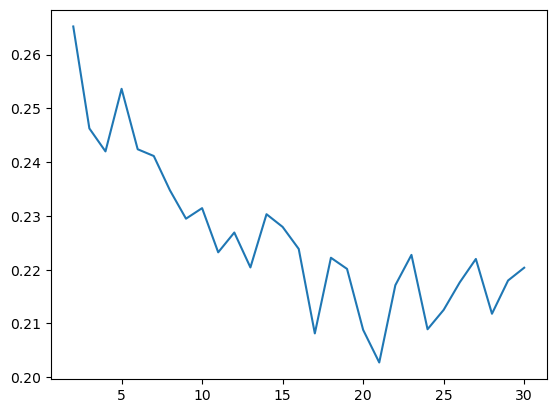

2


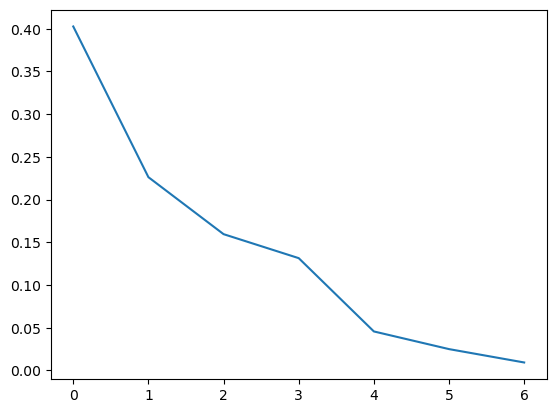

[2.82457696 1.58717173 1.11935942 0.9223705  0.32054698 0.17550227
 0.06575599]
[[-0.506435   -0.50620426 -0.14158553 -0.39883545 -0.34506082 -0.07855886
  -0.42769872]
 [-0.05187101 -0.03955487  0.42544395 -0.29327634 -0.42108472  0.57003047
   0.47590353]
 [-0.43673658 -0.44953506  0.45526865  0.46811364  0.40334137  0.01661958
   0.13348781]
 [ 0.12943787  0.11773858  0.6493069  -0.15699233 -0.23622199 -0.68211799
  -0.04529502]
 [-0.02877202 -0.0936366  -0.233612    0.64089752 -0.6749736  -0.17107239
   0.2005618 ]
 [ 0.29009218  0.02964114  0.3349074   0.30305845 -0.16234909  0.41304116
  -0.71693815]
 [ 0.66959592 -0.71875038 -0.05783128 -0.09245671  0.0564712  -0.05885449
   0.12842763]]


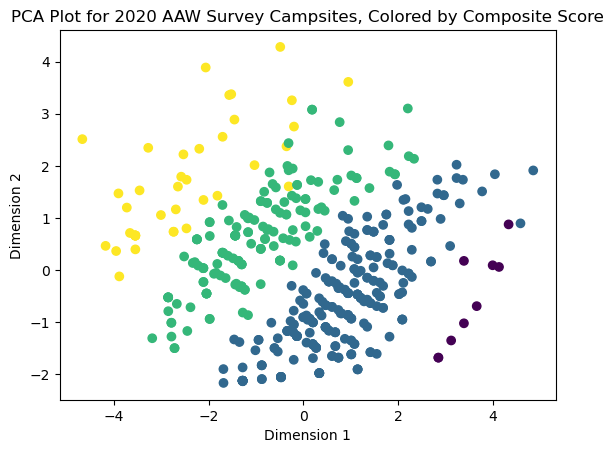

Eigenvectors 
[[ 0.506435    0.05187101  0.43673658  0.12943787  0.66959592 -0.29009218
   0.02877202]
 [ 0.50620426  0.03955487  0.44953506  0.11773858 -0.71875038 -0.02964114
   0.0936366 ]
 [ 0.14158553 -0.42544395 -0.45526865  0.6493069  -0.05783128 -0.3349074
   0.233612  ]
 [ 0.39883545  0.29327634 -0.46811364 -0.15699233 -0.09245671 -0.30305845
  -0.64089752]
 [ 0.34506082  0.42108472 -0.40334137 -0.23622199  0.0564712   0.16234909
   0.6749736 ]
 [ 0.07855886 -0.57003047 -0.01661958 -0.68211799 -0.05885449 -0.41304116
   0.17107239]
 [ 0.42769872 -0.47590353 -0.13348781 -0.04529502  0.12842763  0.71693815
  -0.2005618 ]]

Eigenvalues 
[2.82457696 1.58717173 1.11935942 0.9223705  0.06575599 0.17550227
 0.32054698]
[[-0.506435   -0.50620426 -0.14158553 -0.39883545 -0.34506082 -0.07855886
  -0.42769872]
 [-0.05187101 -0.03955487  0.42544395 -0.29327634 -0.42108472  0.57003047
   0.47590353]]
[2.82457696 1.58717173]


/Users/jwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


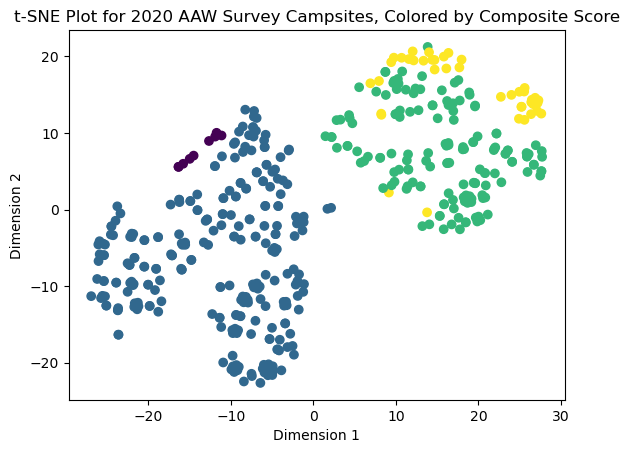

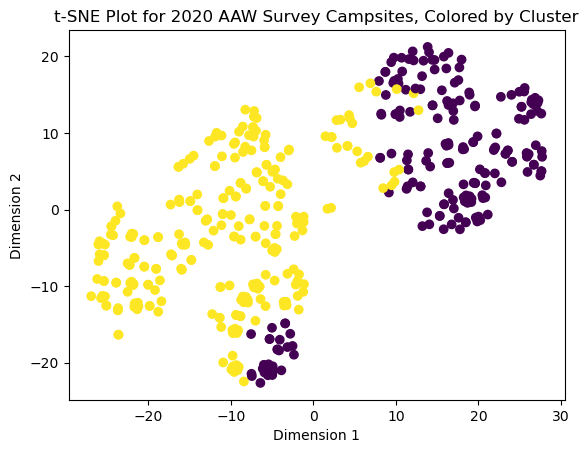

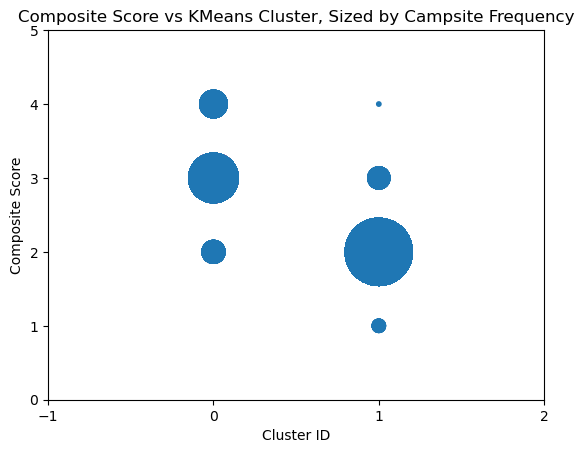

In [14]:
if __name__ == "__main__":
    csv_path = "AggregatedData.csv"
    annotated_path = "AnnotatedData.csv"
    scaled_path = "ScaledData.csv"
    results_dir = 'results'
    max_clusters = 30
    data, scaled_data, features, scores = codify_data(csv_path, annotated_path, scaled_path, results_dir)
    best_k = find_best_k(data, max_clusters)
    print(best_k)
    # find overall avg stats
    clusters = kmeans(scaled_data, best_k)
    scaled_avg, unscaled_avg = composite_score_stats(scaled_data, data, scores)
    # plot dim reduction
    pca, components = plot_clusters(scaled_data, scores)
    tsne_score, tsne_cluster = plot_tsne(scaled_data, scores, clusters.labels_)
    bubble = plot_cluster_score(clusters, scores, best_k)
    centers = [np.around(cluster, 2) for cluster in clusters.cluster_centers_]
    scaled_avg = [np.around(score, 2) for score in scaled_avg]
    unscaled_avg = [np.around(score, 2) for score in unscaled_avg]
    components = [np.around(component, 2) for component in components]
    result_file = 'result_{}.csv'
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    with open(os.path.join(results_dir, result_file.format(best_k)), 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(features)
        writer.writerow(["kmeans clusters"])
        np.savetxt(outfile, centers, fmt="%.2f", delimiter=",")
        writer.writerow(["Components"])
        np.savetxt(outfile, components, fmt="%.2f", delimiter=",")
        writer.writerow(["Average data by composite score"])
        np.savetxt(outfile, scaled_avg, fmt="%.2f", delimiter=",")
        np.savetxt(outfile, unscaled_avg, fmt="%.2f", delimiter=",")

In [15]:
    pca.savefig(os.path.join(results_dir, 'pca_plot.png'), dpi=300)
    tsne_score.savefig(os.path.join(results_dir, 'tsne_plot.png'), dpi=300)
    tsne_cluster.savefig(os.path.join(results_dir, 'tsne_plot_cluster.png'), dpi=300)
    bubble.savefig(os.path.join(results_dir, 'bubble_plot.png'), dpi=300)